In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import HTML

%run -i ../../code/multirover3.py


In [2]:
obsfile1 = "../../NavFiles/cn200100.17o" 
navfile1 = "../../NavFiles/cn200100.17n" 

obsfile2 = "../../NavFiles/tgpm0100.17o"
navfile2 = "../../NavFiles/tgpm0100.17n"

# data, bcestore, rec_pos = rinex_to_dataframe(obsfile, navfile)
#data1, bcestore1, rec_pos1 = rinex_to_dataframe_ionosfe(obsfile1, navfile1)
# data, bcestore, rec_pos = rinex_to_dataframe(obsfile, navfile)
#data2, bcestore2, rec_pos2 = rinex_to_dataframe_ionosfe(obsfile2, navfile2)

In [3]:
import numpy as np
import gpstk
from skimage import io
import matplotlib.pyplot as plt
import pandas as pd
import sys
from sympy import *
from numba import autojit

%matplotlib inline
%run -i ../code/utils.py

In [4]:
def rinex_to_dataframe_ionosfe(obsfile, navfile, silent_mode=False, ion_max=60):
    c = 299792458.

    observation_types=["P1", "P2", "L1", "L2", "C1", "C2", "S1", "S2"]
    obsHeader, obsData = gpstk.readRinex3Obs(obsfile)
    navHeader, navData = gpstk.readRinex3Nav(navfile)
    
    nh=gpstk.readRinexNav(navfile)[0]
    alphas = nh.ionAlpha
    betas  = nh.ionBeta
    gamma=gpstk.GAMMA_GPS ##CARGANDO GAMMA
    
    # setup ephemeris store to look for satellite positions
    bcestore = gpstk.GPSEphemerisStore()
    for navDataObj in navData:
        ephem = navDataObj.toGPSEphemeris()
        bcestore.addEphemeris(ephem)
    bcestore.SearchNear()
    navData.close()

    rec_pos = [obsHeader.antennaPosition[0], obsHeader.antennaPosition[1], obsHeader.antennaPosition[2]]
    
    requested_obstypes = observation_types
    obsidxs = []
    obstypes = []
    obsdefs = np.array([i for i in obsHeader.R2ObsTypes])
    for i in requested_obstypes:
        w = np.where(obsdefs==i)[0]
        if len(w)!=0:
            obsidxs.append(w[0])
            obstypes.append(i)
        else:
            if silent_mode == False:
                print ("WARNING! observation `"+i+"` no present in file "+obsfile)
            #else:
            #    print ""
    #obsidxs, obstypes

    r = []
    for obsObject in obsData:
        prnlist = []
        obsdict = {}
        prnspos = []
        prns_clockbias = []
        prns_relcorr   = []
        prnselev       = []
        prnsaz         = []
        iono_delay     = []
        for i in obstypes:
            obsdict[i]=[]

        gpsTime = gpstk.GPSWeekSecond(obsObject.time)

        for satID, datumList in obsObject.obs.iteritems():
            if satID.system == satID.systemGPS:
                prnlist.append("".join(str(satID).split()))
                eph   = bcestore.findEphemeris(satID, obsObject.time)

                for i in range(len(obsidxs)):
                    obsdict[obstypes[i]].append(obsObject.getObs(satID, obsidxs[i]).data)
                
                P1 = obsObject.getObs(satID, obsidxs[0]).data

                # para reemplazar los valores de P1 que son cero en el rinex
                # por los valores de C1, que deberian ser semejantes
                if np.mean(P1) < 1:
                	#print obstypes[4]
                	P1 = obsObject.getObs(satID, obsidxs[4]).data

                P2 = obsObject.getObs(satID, obsidxs[1]).data
                Id = (1*1/(1-gamma)*(P1-P2)) 
                if np.abs(Id) < ion_max:
                    iono_delay.append(Id)
                else:
                    iono_delay.append(ion_max)
                
                svTime = obsObject.time - P1/c
                svXvt = eph.svXvt(svTime)
                svTime += - svXvt.getClockBias() + svXvt.getRelativityCorr()
                svXvt = eph.svXvt(svTime)
                
                prnspos.append([svXvt.x[0], svXvt.x[1], svXvt.x[2]])
                prns_clockbias.append(svXvt.getClockBias())
                prns_relcorr.append(svXvt.getRelativityCorr())

                prnselev.append(obsHeader.antennaPosition.elvAngle(svXvt.getPos()))
                prnsaz.append(obsHeader.antennaPosition.azAngle(svXvt.getPos()))
                
        r.append([gpsTime.getWeek(), gpsTime.getSOW(), alphas, betas, gamma, np.array(prnlist), np.array(prnspos), np.array(prns_clockbias), 
                  np.array(prns_relcorr), np.array(prnselev), np.array(prnsaz), np.array(iono_delay)] + [np.array(obsdict[i]) for i in obstypes])

    names=["gps_week", "gps_sow", "alphas", "betas", "gamma", "prns", "prns_pos", "prns_clockbias", "prns_relcorr", "prns_elev", "prns_az", "Iono"] + obstypes
    r = pd.DataFrame(r, columns=names)
    obsData.close()
    return r, bcestore, np.array(rec_pos)

In [5]:
@autojit
def predict_coderanges(x, prns_pos, prns_clockbias):
    c = 299792458.0
    f1 = 1575420000.0
    lamda = c/f1
    
    rhos    = compute_distances(x[:3], prns_pos)
    pcodes  = rhos + x[3]-c*prns_clockbias + x[4]*lamda
    return rhos, pcodes

def least_squares_position_codephase(svs, svs_clocks, prs, codes=None, elevs=None, snr=None, max_iters=200, apply_earth_rotation=True):
    
    c = 299792458.0
    f1 = 1575420000.0
    lamda = c/f1
    
    """
        Para emplear la solucion con codigo+fase se necesitan minimo 5 satelites u observaciones.
    """
    if apply_earth_rotation:
        #print type(svs), type(prs)
        svs = apply_earth_rotation_to_svs_position(svs, prs)
    
    if len(svs)==0 or len(prs)==0:
        return np.array([0.,0.,0.,0.]),None, None, None
    
    if len(snr) == 0 or len(elevs)== 0:
        print "SNR observable is needed"
        return np.array([0.,0.,0.,0.]),None, None, None
    
    ri = np.array([0.,0.,0.,0.])
    
    if len(codes) != 0 and len(codes)>5:
        ri = np.array([0.]*4 + [0.]*len(codes))
        bandera = True

    #for i in range(max_iters):
    delta,i = 1,0
    while (norm(delta)>1e-8 and i<max_iters):
        
        rhos, pranges = predict_pseudoranges(ri[:4], svs, svs_clocks)
        b = prs - pranges
        ones = np.ones((len(b), 1))
        zero = np.zeros((len(b), len(b))) #np.zeros((len(b),1))
        A = np.hstack(((ri[:3]-svs)/rhos[:,None], ones, zero))
        
        if bandera:
            # Considerando observables de fase
            rhos2, pcodes  = predict_coderanges(ri, svs, svs_clocks)
            bc = codes - pcodes
            #print np.shape(b), np.shape(bc)
            b = np.hstack((b, bc))
            #print np.shape(b), np.shape(bc)
            lambdas = lamda*np.eye(len(bc)) # *ones 
            #print np.shape((ri[:3]-svs)/rhos[:,None]), np.shape(ones), np.shape(b), np.shape(pcodes)
            ai = np.hstack(((ri[:3]-svs)/rhos[:,None], ones, lambdas))
            #print np.shape(ai), np.shape(b)
            A = np.vstack((A, ai))
            
        if len(snr) != 0 or len(elevs) != 0:
            #wp = len(pranges)*(0.03 + 0.9*np.exp(-snr/elevs))#elevs/30.))
            wp = len(pranges)*(0.03 + 0.9*np.exp(-snr/elevs))#elevs/30.))
            wc = len(pranges)*(0.07 + 0.6*np.exp(-snr/elevs))#elevs/30.))
            w = np.hstack((wp, wc))
            #print np.shape(w), np.shape((A.T.dot(w*np.eye(len(w))))), np.shape(A.T), np.shape(b)
             #  + 1e-3*np.eye(len(ri))
            delta =  np.linalg.pinv((A.T.dot(w*np.eye(len(w)))).dot(A)).dot(A.T.dot(w*np.eye(len(w)))).dot(b)
        else:
            delta =  np.linalg.pinv(A.T.dot(A)).dot(A.T).dot(b)
            
        ri += delta
        i+=1
    return ri, A, b, delta

def weight_least_squares_position(svs, svs_clocks, prs, elevs, snr, max_iters=200, apply_earth_rotation=True):

    if apply_earth_rotation:
        svs = apply_earth_rotation_to_svs_position(svs, prs)

    if len(svs)==0 or len(prs)==0 or len(elevs)==0 or len(snr)==0:
        return np.array([0.,0.,0.,0.]),None, None, None

    ri = np.array([0.,0.,0.,0.])

    #for i in range(max_iters):
    delta,i = 1,0
    while (norm(delta)>1e-8 and i<max_iters):
        rhos, pranges = predict_pseudoranges(ri, svs, svs_clocks)
        b = prs - pranges
        A = np.hstack(((ri[:3]-svs)/rhos[:,None],np.ones((len(b), 1))))
        
        w= len(pranges)*(0.03 + 0.9*np.exp(-snr/elevs))
        #wc = len(pranges)*(0.07 + 0.6*np.exp(-snr/elevs))#elevs/30.))
        #w = np.hstack((wp, wc))
        delta =  np.linalg.pinv((A.T.dot(w*np.eye(len(w)))).dot(A)).dot(A.T.dot(w*np.eye(len(w)))).dot(b)
        #delta =  np.linalg.pinv(A.T.dot(A)).dot(A.T).dot(b)
        ri += delta
        i+=1
    return ri, A, b, delta

In [6]:
def inspect_rinex(obsfile, navfile, silent_mode=False):
    obsHeader, obsData = gpstk.readRinex3Obs(obsfile)
    navHeader, navData = gpstk.readRinex3Nav(navfile)
    # setup ephemeris store to look for satellite positions
    bcestore = gpstk.GPSEphemerisStore()
    for navDataObj in navData:
        ephem = navDataObj.toGPSEphemeris()
        bcestore.addEphemeris(ephem)
    bcestore.SearchNear()
    navData.close()

    silent_mode = False
    requested_obstypes = ["P1", "P2", "L1", "L2", "C1", "C2", "S1", "S2"]
    obsidxs = []
    obstypes = []
    obsdefs = np.array([i for i in obsHeader.R2ObsTypes])
    for i in requested_obstypes:
        w = np.where(obsdefs==i)[0]
        if len(w)!=0:
            obsidxs.append(w[0])
            obstypes.append(i)
        else:
            if silent_mode == False:
                print ("WARNING! observation `"+i+"` no present in file "+obsfile)
            #else:
                #print ""
                
    obsObject = obsData.next()
    print "Time of observation", obsObject.time
    print "SatID GPS  GLON",
    for P1_idx, otype in zip(obsidxs, obstypes):
            print "\t  ", otype,
    print ""
    
    for satID, datumList in obsObject.obs.iteritems():
        
        isGPS     = True if satID.system==satID.systemGPS else False
        isGlonass = True if satID.system==satID.systemGlonass else False
        
        print "  %2d %5s %5s"%(satID.id, isGPS, isGlonass),
        
        for P1_idx, otype in zip(obsidxs, obstypes):
            P1 = obsObject.getObs(satID, P1_idx).data
            print "%10.3f"%( P1),
        
        print ""



        #print "  %2d %5s %5s %10.3f %10.3f %10.3f %10.3f"%(satID.id, isGPS, isGlonass, P1, P2, L1, L2)

In [7]:
inspect_rinex(obsfile1, navfile1)

WARNING! observation `C2` no present in file ../../NavFiles/cn200100.17o
Time of observation 2457764 00000000 0.000000000000000 GPS
SatID GPS  GLON 	   P1 	   P2 	   L1 	   L2 	   C1 	   S1 	   S2 
   3  True False      0.000 21996347.656 115591580.691 90071387.316 21996341.000     45.400     34.500 
   8  True False      0.000 21630547.074 113669137.840 88573490.250 21630540.766     48.100     36.300 
  14  True False      0.000 22693552.098 119255486.894 92926394.720 22693547.430     43.300     27.000 
  16  True False      0.000 21612354.820 113573817.058 88499066.088 21612350.664     49.700     35.100 
  22  True False      0.000 21849800.500 114821498.007 89471296.808 21849798.336     47.400     35.600 
  23  True False      0.000 21842666.535 114784087.868 89442080.991 21842664.914     50.000     36.100 
  26  True False      0.000 23815563.547 125151697.596 97520811.850 23815555.422     39.700     21.800 
  27  True False      0.000 20589903.434 108200714.316 84312246.742 205898

WARNING! observation `C2` no present in file ../../NavFiles/cn200100.17o
actual                 [  848061.4484 -6236542.797   1029565.3325]
RAIM computed          [  848064.77277568 -6236568.89103697  1029565.96007496]
RAIM error             26.3124322216
LS computed            [  8.48072504e+05  -6.23657537e+06   1.02956491e+06   2.51693186e+01]
LS error               34.3961418559
WLS computed           [  8.48078221e+05  -6.23656234e+06   1.02956342e+06   1.65229587e+01]
WLS error              25.8259610701
LS Code+Phasecomputed  [  848078.22108198 -6236562.3419089   1029563.42097121]
LS errorCP             25.8259611017


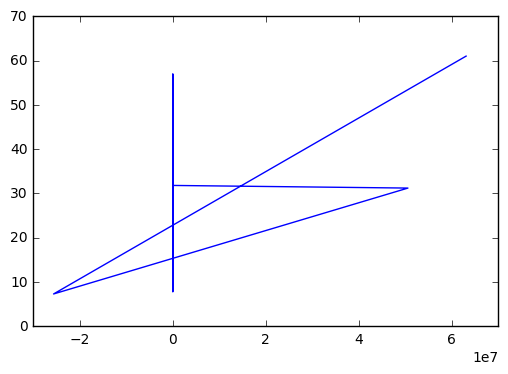

In [8]:
data, bcestore, rec_pos = rinex_to_dataframe_ionosfe(obsfile1, navfile1)

codigo = "C1"
fase = "L1"

o = data.iloc[1900]
pranges = o[codigo]
codes = o[fase]

idxs = np.arange(len(pranges))
p1 = np.array(pranges)[idxs] 
l1 = np.array(codes)[idxs]
pos = np.array(o.prns_pos)[idxs]
clocks = np.array(o.prns_clockbias)[idxs]
p1,pos = pranges[idxs], o.prns_pos[idxs]
clocks = o.prns_clockbias[idxs]
raim_computed_pos   = compute_raim_position(o.gps_week, o.gps_sow, o.prns, o.prns_pos, pranges, bcestore)
wls_computed,  A,b,_ = weight_least_squares_position(pos, clocks, p1, elevs=np.array(o.prns_elev), snr=np.array(o.S1))
ls_computed_pos ,  A,b,_ = compute_least_squares_position(pos, clocks, p1)

ls_computed_pos_CP,A,b,delta = least_squares_position_codephase(pos, clocks, p1, codes=codes, elevs=np.array(o.prns_elev), snr=np.array(o.S1))

#print delta, np.array(o.prns_elev)
plt.plot(delta[:len(np.array(o.prns_elev))], np.array(o.prns_elev))

print "actual                ", rec_pos
print "RAIM computed         ", raim_computed_pos
print "RAIM error            ", np.linalg.norm(raim_computed_pos - rec_pos)
print "LS computed           ", ls_computed_pos
print "LS error              ", np.linalg.norm(ls_computed_pos[:3] - rec_pos)
print "WLS computed          ", wls_computed
print "WLS error             ", np.linalg.norm(wls_computed[:3] - rec_pos)
print "LS Code+Phasecomputed ", ls_computed_pos_CP[:3]
print "LS errorCP            ", np.linalg.norm(ls_computed_pos_CP[:3] - rec_pos)

In [9]:
resolution = 1000
data, bcestore, rec_pos = rinex_to_dataframe_ionosfe(obsfile1, navfile1)

WARNING! observation `C2` no present in file ../../NavFiles/cn200100.17o


In [10]:
raim_errs = []
ls_errs   = []
lscp_errs   = []
wls_errs   = []
hdops, vdops = [], []

for i in range(len(data)):
    
    if i % resolution == 0:
        o = data.iloc[i]
        pranges = o[codigo]
        codes = o[fase]

        idxs = np.arange(len(pranges))
        p1 = np.array(pranges)[idxs] 
        l1 = np.array(codes)[idxs]
        pos = np.array(o.prns_pos)[idxs]
        clocks = np.array(o.prns_clockbias)[idxs]
        p1,pos = pranges[idxs], o.prns_pos[idxs]
        clocks = o.prns_clockbias[idxs]

        #p1,clocks, pos = np.array(o.P1), np.array(o.prns_clockbias), np.array(o.prns_pos)

        if len(o.prns)>=5:
            #print "hello"
            vdop, hdop = get_dop(o)
            raim_computed_pos  = compute_raim_position(o.gps_week, o.gps_sow, o.prns, pos, o.P1, bcestore)
            ls_computed_pos,_,_,_   = compute_least_squares_position(pos, clocks, p1)
            vdop, hdop     = get_dop(o)
            ls_cp,_,_,d    = least_squares_position_codephase(pos, clocks, p1, codes=codes, elevs=np.array(o.prns_elev), snr=np.array(o.S1))
            wls_pos, A,b,_ = weight_least_squares_position(pos, clocks, p1, elevs=np.array(o.prns_elev), snr=np.array(o.S1))


            raim_err = np.linalg.norm(raim_computed_pos - rec_pos)
            ls_err   = np.linalg.norm(ls_computed_pos[:3] - rec_pos)
            wls_err   = np.linalg.norm(wls_pos[:3] - rec_pos)
            ls_err_cp = np.linalg.norm(ls_cp[:3] - rec_pos)

            raim_errs.append(raim_err)
            ls_errs.append(ls_err)
            wls_errs.append(wls_err)
            lscp_errs.append(ls_err_cp)

ls_errs = np.array(ls_errs)
wls_errs = np.array(wls_errs)
lscp_errs = np.array(lscp_errs)
raim_errs = np.array(raim_errs)

In [11]:
print np.mean(raim_errs), np.mean(wls_errs), np.mean(ls_errs), np.mean(lscp_errs)

6973517.47003 20.8839325928 22.9391305151 20.8839326435


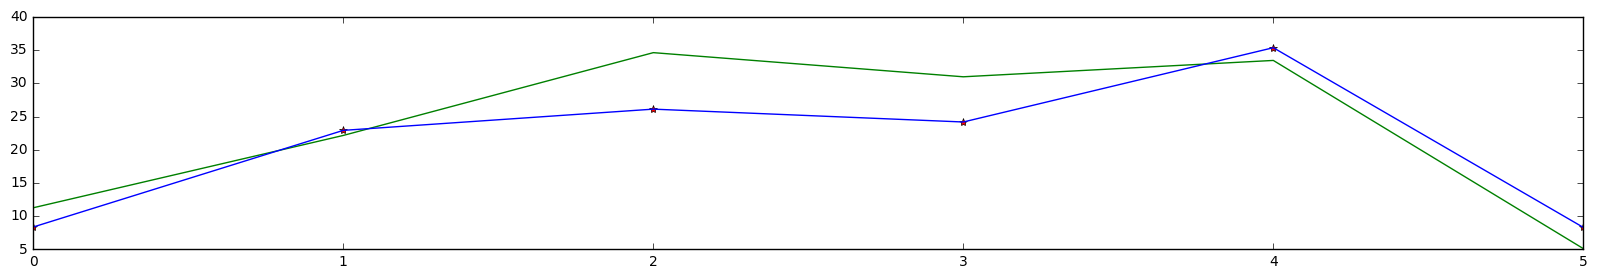

In [12]:
fig=plt.figure(figsize=(20,3))
#plt.plot(raim_errs, 'r')
plt.plot(ls_errs,     'g')
plt.plot(wls_errs,    'r*')
plt.plot(lscp_errs,   'b')

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import HTML

%run -i ../../code/multirover3.py


dia1 = "060" #"026" #"010"
dian = "060" #"026" #"010"
ano = "2017"

Observable = "C1"
# Variables de la grafica
error_max = 100

# Ubicacion de la Rinex local DB 
Rinex_dataBase      = "../../new_data/"
Simu_Folder         = getcwd() +"/" + "Temp_Simul_data"

# agregando nuevos pares de estaciones (que no estan en el kmz)
#parejas_kmz        = get_data_stations("./Coconet_sites_2016.kmz", 1e3)
#parejas_kmz        = get_data_stations("./UNAVCO_perm.kmz", 300) # 110
parejas_kmz = {}

parejas_kmz[0] = ("OLVN", "AIRS", "NWBL",)
parejas_kmz[1] = ("BARA", "TGDR", "JME2",)
parejas_kmz[2] = ("ljrn", "p553", "p554", "fzhs",)
parejas_kmz[3] = ("CN20", "TGPM",)
parejas_kmz[4] = ('TGMX', 'UNPM',)


RinexDB = descarga_Rinex_Compri(Rinex_dataBase, parejas_kmz, dia1, dian, ano)
## Leer los rinex almacenado en mi equipo
RinexDB = read_Rinex_Compri(Rinex_dataBase, parejas_kmz)

df_res = pd.DataFrame()


 Descargando Nuevos Archivos ....
************************

	 [Estacion] 	 [dia GPS] 		 [RESULTADO]
	 olvn
			 060 		 No encontrados Ficheros ['d']
	 airs
			 060 		 No encontrados Ficheros ['d']
	 nwbl
			 060 		 Descarga Exitosa!!!
	 bara
			 060 		 Descarga Exitosa!!!
	 tgdr
			 060 		 Descarga Exitosa!!!
	 jme2
			 060 		 Descarga Exitosa!!!
	 ljrn
			 060 		 Descarga Exitosa!!!
	 p553
			 060 		 Descarga Exitosa!!!
	 p554
			 060 		 Descarga Exitosa!!!
	 fzhs
			 060 		 Descarga Exitosa!!!
	 cn20
			 060 		 Descarga Exitosa!!!
	 tgpm
			 060 		 Descarga Exitosa!!!
	 tgmx
			 060 		 Descarga Exitosa!!!
	 unpm
			 060 		 Descarga Exitosa!!!
Descarga Finalizada!! 



In [14]:
obsfile1 = "../../NavFiles/cn200100.17o" 
navfile1 = "../../NavFiles/cn200100.17n" 

obsfile2 = "../../NavFiles/tgpm0100.17o"
navfile2 = "../../NavFiles/tgpm0100.17n"

# data, bcestore, rec_pos = rinex_to_dataframe(obsfile, navfile)
data1, bcestore1, rec_pos1 = rinex_to_dataframe_ionosfe(obsfile1, navfile1)
# data, bcestore, rec_pos = rinex_to_dataframe(obsfile, navfile)
data2, bcestore2, rec_pos2 = rinex_to_dataframe_ionosfe(obsfile2, navfile2)

data = []
realpos = []

data.append(data1)
realpos.append(rec_pos1)
data.append(data2)
realpos.append(rec_pos2)

print realpos
pareja = parejas_kmz[3]
res_plot = 1000

WARNING! observation `C2` no present in file ../../NavFiles/cn200100.17o
WARNING! observation `C2` no present in file ../../NavFiles/tgpm0100.17o
[array([  848061.4484, -6236542.797 ,  1029565.3325]), array([  847892.236 , -6236590.6185,  1029471.4117])]


In [16]:

import re 
# http://stackoverflow.com/questions/2669059/how-to-sort-alpha-numeric-set-in-python
def sorted_nicely( l ): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

def get_data(dat_common, data_rx, epoc, csats, station_name):
        import types
        requested_obstypes = ["C1", "C2", "P1", "P2", "L1", "L2", "S1", "S2"]
        columns2search = ["prns", "alphas", "betas", "prns_elev", "prns_az", "prns_clockbias", "prns_pos", "Iono"]

        col_rename = {k:k+"_master" for k in columns2search+requested_obstypes}
        col_rename["prns"] = "prns"

        r = []
        data = {}

        # http://thomas-cokelaer.info/blog/2014/06/pandas-how-to-compare-dataframe-with-none/
        if len(dat_common.columns) == 0: #isinstance(dat_common, types.NoneType) == True: #dat_common.empty:
            #print('DataFrame is empty!')
            obstypes = [c for c in data_rx.columns if c in requested_obstypes]

            #print "csats", len(csats)

            idx1 = []
            for k, sat in enumerate(data_rx.iloc[epoc].prns):
                if sat in csats:
                    idx1.append(k)

            columns = ["prns", "prns_elev", "prns_az", "prns_clockbias", "prns_pos", "Iono"]+obstypes
            names = []

            for col in data_rx.columns:
                if col in columns:
                    names.append(col)
                    values = data_rx.iloc[epoc][col][idx1]
                elif col == "prns":
                    names.append(col)
                    values = csats
                else:
                    names.append(col)
                    values = np.array(data_rx.iloc[epoc][col])

                r.append(values)

            r = pd.Series(r, index=names).to_frame()
            df_temp =pd.DataFrame(r.T, columns=names)
            df_temp.rename(columns=col_rename, inplace=True)
            return df_temp

        else:

            obstypes = [c for c in data_rx.columns if c in requested_obstypes]

            idx1 = []
            for k, sat in enumerate(data_rx.iloc[epoc].prns):
                if sat in csats:
                    idx1.append(k)

            for obstype in obstypes:
                dat_common[obstype+"_"+station_name] = pd.Series([data_rx.iloc[epoc][obstype][idx1]], index=dat_common.index)

            columns = ["prns_elev", "prns_az", "prns_clockbias", "prns_pos", "Iono"]

            for col in columns2search:
                if col in columns:
                    values = data_rx.iloc[epoc][col][idx1]
                    key = col+"_"+station_name
                elif col == "prns":
                    values = csats
                    key = "csats"
                else:
                    key = col+"_"+station_name
                    values = np.array(data_rx.iloc[epoc][col])

                dat_common[key] = pd.Series([values], index=dat_common.index)

        return dat_common
    
    
    
    
def coop_ls_code_phase_multirover(gpstime, receivers, d_est, dat,
                              Obser="C1",
                              max_iters=200,
                              apply_earth_rotation=True, 
                              iono_model_master=None,
                              iono_model_rover =None):
    
    def get_sat_elv_az(svs, rx):
        """
        http://www.naic.edu/aisr/GPSTEC/drewstuff/MATLAB/elavazim.m
        https://goo.gl/2Kt8Pf
        # https://sourceforge.isae.fr/projects/building-blocks-for-a-leo-ground-station/wiki/Distance_Elevation_and_Azimuth_Calculation
        """
        #svs = apply_earth_rotation_to_svs_position(svs, prs)

        #d_svs = r_com[:,:3]/r_mag[:, None]
        svs_enu = ecef2enu(svs, rx)

        east, north, up  = svs_enu[0], svs_enu[1], svs_enu[2]

        elevation = up/np.linalg.norm(svs_enu, axis=0)
        azimuth = np.arctan2(east,north)#radians
        idx = np.where(azimuth<0)
        azimuth[idx] += 2*np.pi;
        return elevation, azimuth # radians

    def apply_earth_rotation_to_svs_position(svs, prs):
        c = 299792458
        we = 7.2921159e-5
        rpos = np.zeros(svs.shape)
        pos = np.array(svs)
        for i in range(len(pos)):
            dt = prs[i]/c
            theta = we*dt
            R = np.array([[np.cos(theta), np.sin(theta),0.],[-np.sin(theta), np.cos(theta),0.],[0.,0.,1.]])
            rpos[i] = R.dot(pos[i])
        svs = np.array(rpos)
        return svs
    
    def compute_distances(rc, svs):
        return np.linalg.norm(rc-svs, axis=1)

    def Klobuchar(A,E,time, rx_pos, alphas, betas): 
        ####klobuchar  model 

        lat, lon, alt = ecef2lla(X=rx_pos[0], Y=rx_pos[1], Z=rx_pos[2])
        C=2.99792458e8 

        ######bla bla 
        phi=(0.0137/(E-0.11))-0.022
        psi=lat+phi*np.cos(A)#2
        if psi > 0.416:
            psi=psi+0.416
        elif psi < -0.416:
            psi=psi-0.416

        lampda=lon+(phi*np.sin(A))/np.cos(psi)#3
        phi_m=lampda+0.064*np.cos(psi-1.617)#4
        t=43200*lampda+time#.getSecondOfDay()#5
        if t > 86400:
            t=t-86400
        elif t < 0:
            t=t+86400
        ##basados en el modelo expuesto en el link, se cambian el exponente de la sumatoria.
        ##http://what-when-how.com/gps/ionospheric-effects-physical-influences-of-gps-surveying-part-2/
        A_I=alphas[0]+alphas[1]*phi_m+alphas[2]*phi_m**2+alphas[3]*phi_m**3 #6
        if A_I < 0:
            A_I=0

        P_I=betas[0]+betas[1]*phi_m+betas[2]*phi_m**2+betas[3]*phi_m**3 #7
        if P_I < 72000:
            P_I=72000

        X_I=2*np.pi*(t-50400)/P_I #8
        F=1+16*(0.53-E)**3#9

        if np.fabs(X_I) > 1.57:#10
            IL1_GPS=((5e-9)+A_I*(1-(((X_I)**2)/2)+((X_I)**4)/24))*F*C
        elif np.fabs(X_I) < 1.57:
            IL1_GPS=(5e-9)*F*C
        else :
            IL1_GPS=(5e-9)*F*C
        return IL1_GPS#/F

    def predict_pseudoranges(x, prns_pos, prns_clockbias):
        c = 299792458
        rhos    = compute_distances(x[:3], prns_pos)
        pranges = rhos + x[3]-c*prns_clockbias
        return rhos, pranges
    
    def predict_pseudoranges_iono(x, svs, prns_clockbias, dat, apply_iono_model=None):
        c = 299792458
        R_earth = 6367444.657  # 6,371 km
        h_iono  = 400e3
        
        def iono_3dmodel(rs, d_iono, elevs):
            num1 = d_iono**2*(np.sqrt(rs**2*np.cos(elevs))*np.sin(elevs)**2)
            den1 = np.power(2*rs*np.cos(elevs)**2, 3) #8*rs**3*np.cos(elev)**6 # 

            num2 = rs
            den2 = rs*np.cos(elevs)

            return num2/den2 + 1/8*(d_iono/rs)*(d_iono/rs)*np.tan(elevs) #num1/den1
        
        if apply_iono_model=='taylor':
            #print "a", apply_iono_model
            rs, d_iono = R_earth+h_iono, 10e3
            elv, az = get_sat_elv_az(svs, x[:3])
            io1 = iono_3dmodel(rs, d_iono, elv)

        elif apply_iono_model=='standard':
            #print apply_iono_model
            R = R_earth
            elevs, az = get_sat_elv_az(svs, x[:3])
            io1 = np.array(1/np.cos(np.arcsin(R/(R+350000))*np.sin(elevs)))
            #io2 = np.array(1/np.cos(np.arcsin(R/(R+350000))*np.sin(elv2)))

        elif apply_iono_model=='wallas':
            e, a = get_sat_elv_az(svs, x[:3])
            #print len(S1), len(e), len(a)
            io1 = (a/40.3)*(dat["S1_master"]/e)
            #print len(io1), io1

        elif apply_iono_model=='klobu':
            elv, az = get_sat_elv_az(svs, x[:3])
            io1 = np.array([Klobuchar(a,e, gpstime, ri[:3], dat.alphas_master, dat.betas_master) for a, e in zip(az, elv)])

        elif apply_iono_model=='dual_freq':
            #print apply_iono_model, dat["Iono_master"][:4], dat["P1_master"][:4], dat["P2_master"][:4]
            io1 = dat["Iono_master"]

        else:
            io1 = np.zeros(len(prns_clockbias))
            pass
    
        rhos    = compute_distances(x[:3], svs)
        #print np.shape(rhos), np.shape(x[3]), np.shape(svs), np.shape(prns_clockbias)
        pranges = rhos + x[3]-c*prns_clockbias - io1 #iono_3dmodel(elevs)
        return rhos, pranges

    
    # initialize vector of variables
    n_rx = len(receivers)  #numero de receptores en cooperativo
    ri = np.hstack((np.zeros(4), np.ones(4*(n_rx-1))))
    
    svs = dat['prns_pos_master']
    n_sats = len(svs)
    n_vars = 4
    #n, m = 2*n_sats+1, 2*n_vars
    n, m = (n_rx*n_sats + n_rx-1), n_rx*n_vars
    
    if apply_earth_rotation:
        svs = apply_earth_rotation_to_svs_position(dat['prns_pos_master'], dat[Obser+'_master'])
    
    if len(svs)==0 or len(dat[Obser+'_master'])==0:
        return np.zeros(4*n_rx),None, None, None
 
    delta,i = 1,0
    #print "iono model"
    #print "rov", iono_model_rover, "mas", iono_model_master

    while (norm(delta)>1e-8 and i<max_iters):
        
        # for master station component
        A = np.zeros((n, m))
        prs = np.zeros(n)
        pranges = np.zeros(n)
        
        rhos_a, pranges_a = predict_pseudoranges_iono(ri[:4], svs, 
                                                      dat['prns_clockbias_master'],
                                                      dat,
                                                      apply_iono_model=iono_model_master)
        Aa = np.hstack(((ri[:3] - svs)/rhos_a[:,None], np.ones((n_sats, 1))))
        
        # component asociated to position of local receiver
        A[:n_sats, :n_vars] = Aa
        #A[:n_sats, n_vars:] = np.zeros(np.shape(A[:n_sats,n_vars:]))
        
        prs[:n_sats]     = dat[Obser+'_master'] #np.hstack((dat[Obser+'_master'])).reshape(-1,1)
        pranges[:n_sats] = pranges_a
        
        w = len(pranges)*(0.003 + 0.09*np.exp(-dat['S1_master']/dat['prns_elev_master']))
        
        c = 0
        for k, station in enumerate(receivers):
            if k != 0:

                """ MODELO DISTANCIA.
                OJO INVERTIR ESTO PARA CAMBIAR LA DIRECCION DEL VECTOR DISTANCIAS
                """
                d_model = np.linalg.norm(ri[4*k:4*(k+1)-1] - ri[:3])
                Ad = np.hstack(((ri[4*k:4*(k+1)-1] - ri[:3])/d_model))#[:,None]))

                """ MODELO PSEUDORANGES.
                """
                rhos_b, pranges_b = predict_pseudoranges_iono(ri[4*k:4*(k+1)], svs, 
                                                              dat['prns_clockbias'+"_"+station],
                                                              dat,
                                                              apply_iono_model=iono_model_rover)
                """ prs y pranges construction."""
                prs2 = dat[Obser+"_"+station]
                ini = k*n_sats + c
                fin = (k+1)*n_sats+1 + c
                
                prs[ini:fin]     = np.hstack((prs2, np.array(d_est[k-1])))
                pranges[ini:fin] = np.hstack((pranges_b, d_model))

                """ A Matrix construction.
                """
                # get cosine director from each receiver to sats
                Ab = np.hstack(((ri[4*k:4*(k+1)-1]- svs)/rhos_b[:,None], np.ones((n_sats, 1))))

                # component asociated to position of remote receiver
                A[ini:fin, k*n_vars:(k+1)*n_vars] = np.vstack((Ab, np.hstack((Ad[:3], np.zeros(1)))))
                c += 1 # para avanzar la posicion de Ad en cada rover
                #print A
                
                wp = len(pranges)*(0.003 + 0.009*np.exp(-dat['S1'+"_"+station]/dat['prns_elev'+"_"+station]))
                w = np.hstack((w, wp, np.ones(1)))
        
        """ LS computation.
        """
        
        b     = prs - pranges
        
        delta =  np.linalg.pinv((A.T.dot(w*np.eye(len(w)))).dot(A)).dot(A.T.dot(w*np.eye(len(w)))).dot(b)
        #delta =  np.linalg.pinv(A.T.dot(A)).dot(A.T).dot(b)
        ri    += delta#.flatten('F')
        i     += 1
    return ri, A, b, delta

def simple_test_multirover_inner(data_common, pareja, real_pos, Obser="C1", 
                           local=None, remote=None, dist=None,
                           iono_model_master=None,
                           iono_model_rover =None,
                           res_plot=300, silent_exec=False):

    Results = {}
    r = []

    dc_est = []
    d_real = []
    stdalone_pos = []
    stdalone_err = []
    coop_pos = []
    coop_err = []
    coop_t = []

    #print ("\t\t Rinex Observation: "), epoc
    """
    for i in range(len(data_common)):
        if i % res_plot == 0:
            print i,
    """
    dat = data_common.iloc[0]
    gps_sow = dat.gps_sow

    #print "Satelites en común ", len(dat['csats']), len(dat['prns'])
    if len(dat['prns'])>=4:

        # Metodos desarrollados
        ## Compute standalone positions
        for k, station in enumerate(pareja):
            if k == 0:

                #print np.shape(dat.loc['prns_pos_master']), np.shape(dat[Obser+'_master']), np.shape(dat['prns_clockbias_master'])

                #print "d", np.shape(dat.loc['prns_clockbias_master'])
                posstd,_,_,_ = compute_least_squares_position(dat.loc['prns_pos_master'],
                                                              dat.loc['prns_clockbias_master'],
                                                              dat.loc[Obser+'_master'])
                err = np.linalg.norm(posstd[:3] - real_pos[k])
                
                stdalone_pos.append(posstd[:3])
                stdalone_err.append(err)

            else:
                #print "e", np.shape(dat.loc['prns_clockbias_'+station])
                posstd,_,_,_ = compute_least_squares_position(dat.loc['prns_pos_'+station],
                                                              dat.loc['prns_clockbias_'+station],
                                                              dat.loc[Obser+"_"+station])
                err = np.linalg.norm(posstd[:3] - real_pos[k])

                stdalone_pos.append(posstd[:3])
                stdalone_err.append(err)

        # compute distances between receivers
        for k, station in enumerate(pareja):
            if k != 0:
                #print k, stdalone_pos[0], stdalone_pos[k]
                dc, teta, dc_vec = d_teta_calc(stdalone_pos[0], stdalone_pos[k])
                dr, teta, dc_vec = d_teta_calc(real_pos[0], real_pos[k])
                dc_est.append(dc)
                d_real.append(dr)

        start_time = time.time()

        if is_number(dist):
            noise = np.random.normal(-1, 1, len(d_real))
            dist = np.array(d_real) + (dist/100)*noise
            """
            ri,_,_,_ = coop_ls_solver_multirover(dat["gps_sow"], pareja, dist, dat,
                                             iono_model_master=iono_model_master,
                                             iono_model_rover =iono_model_rover)
            """
            ri,_,_,_ = coop_ls_code_phase_multirover(dat["gps_sow"], pareja, dist, dat,
                                                 iono_model_master=iono_model_master,
                                                 iono_model_rover =iono_model_rover)
            
        elif dist == None:
            dist = dc_est
            """
            ri,_,_,_ = coop_ls_solver_multirover(dat["gps_sow"], pareja, dist, dat,
                                                 iono_model_master=iono_model_master,
                                                 iono_model_rover =iono_model_rover)
            """
            ri,_,_,_ = coop_ls_code_phase_multirover(dat["gps_sow"], pareja, dist, dat,
                                                 iono_model_master=iono_model_master,
                                                 iono_model_rover =iono_model_rover)
        coop_t = time.time() - start_time

        #r.append([gps_sow, real_pos, d_real, dc_est, coop_t, ri, data_common])  

        c = 0
        station_list = []
        for k, station in enumerate(pareja):
            station_list.append(station)
            if k == 0:
                coop_pos.append(ri[4*k:4*(k+1)-1])
                coop_err.append(np.linalg.norm(ri[4*k:4*(k+1)-1] - real_pos[k]))
            else:
                ini = 4*k #+ c
                fin = 4*(k+1)-1 # + c
                #print
                #print k, ini, fin, ri, np.shape(ri[ini:fin]), np.shape(real_pos[k])
                coop_pos.append(ri[ini:fin])
                coop_err.append(np.linalg.norm(ri[ini:fin] - real_pos[k]))
                c += 1


        #print dc_est
        print "st", stdalone_err
        print "cp", coop_err
        #r.append([gps_sow, real_pos, d_real, dc_est, stdalone_pos, stdalone_err, coop_pos, coop_err, coop_t, ri, data_common])    
        r = [gps_sow, real_pos, station_list, dist, d_real, dc_est, stdalone_pos, stdalone_err, coop_pos, coop_err, coop_t, ri, data_common]    
    else:
        return

    names = ["gps_sow" ,"real_pos", "station_list", "d", "dreal", "d_calc", "stdlone_pos", "stdlone_err", "coop_pos", "coop_err", "coop_time[s]", "rc_sol", "data_common"]

    return r, names #pd.DataFrame(r, columns=names)# Results

def multirover_test(Obser, error_max, parejas_kmz, RinexDB, dia1, dian, ano, distances=None,
                         Simu_Folder=None, 
                         res_plot=1000, 
                         iono_model_master=None,
                         iono_model_rover=None, 
                         silent_exec=False):

    def clean_folder(abspath_Folder, silent_mode=True):
            cmd = "rm -rf "+abspath_Folder+"/*"
            if silent_mode == False:
                print ("\n"+cmd)
            system(cmd)
        
        
    import re 
    # http://stackoverflow.com/questions/2669059/how-to-sort-alpha-numeric-set-in-python
    def sorted_nicely( l ): 
        """ Sort the given iterable in the way that humans expect.""" 
        convert = lambda text: int(text) if text.isdigit() else text 
        alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
        return sorted(l, key = alphanum_key)
       
    def extract_rinex_files(RinexDB, k, RX, Simu_Folder, required_files=['n', 'o']):

        Temp = {}
        matches = [x for x in RinexDB.keys() if RX.lower() == x]
        
        
        if len(matches)> 0:
            
            RX = matches[0]
            for Obstype in RinexDB[RX].keys():
                station, ObsType = splitext(RinexDB[RX][Obstype])
                path = RinexDB[RX][Obstype]
                dirname, zipname = split(path)
                fname, ext = splitext(zipname)

                #print fname, ext, path
                cmd = "cp "+path+" "+Simu_Folder+"/"+zipname
                system(cmd)
                cmd2 = "gunzip "+Simu_Folder+"/"+zipname
                system(cmd2)

                if isfile(Simu_Folder+"/"+fname):
                    if k==0:
                        Temp.setdefault("master_"+RX,{})[Obstype[0]] = Simu_Folder+"/"+fname
                        Temp["master_"+RX].update({Obstype:path})
                    else:
                        Temp.setdefault("rover"+str(k)+"_"+RX,{})[Obstype[0]] = Simu_Folder+"/"+fname
                        Temp["rover"+str(k)+"_"+RX].update({Obstype:path})
                else:
                    if k==0:
                        Temp.setdefault("master_"+RX,{})[Obstype[0]] = ""
                        Temp["master_"+RX].update({Obstype:""})
                    else:
                        Temp.setdefault("rover"+str(k)+"_"+RX,{})[Obstype[0]] = ""
                        Temp["rover"+str(k)+"_"+RX].update({Obstype:""})

            station = Temp.keys()[0]
            files = [f for f in required_files if f in Temp[station].keys()]
            
            if (len(files) >= len(required_files)):
                return Temp
            else:
                return {}
        else:
            return {}
    
    if Simu_Folder==None:
        Simu_Folder = getcwd()+"/Temp_Simul_data"
        cmd1 = "mkdir -p " + Simu_Folder    # COMANDO CREA CARPETA temporal
        system(cmd1)

    #print parejas_kmz
    print "\t [Station Pair] \t [GPS day] \t [year] \t\t [Process status]\n"
    
    Results = {}
    #data_common = {}
    
    for k, pareja in parejas_kmz.iteritems():
        data_common = pd.DataFrame()

        for d in range(int(dia1), int(dian)+1):

            Obsfiles = {}
            for k, station in enumerate(pareja):

                fname = str(station)+str(process_day2(d))+"."+ano[-2:]
                Obsfiles.update(extract_rinex_files(RinexDB, k, fname, Simu_Folder))
                
                if any(Obsfiles):
                    error = False
                else:
                    error = True
            
            if error or len(Obsfiles)<2 or len(Obsfiles)<2:
                #print "WARNING! %s Aborting execution: missing rinex files for %s \n"%(tick_equis(1), pareja)
                print "WARNING! Aborting execution: missing rinex files for %s \n"%(str(pareja))
            else:
                par = tuple(Obsfiles.keys())
                #print "\t %s \t\t %s \t\t %s \t\t %s Running..."%(pareja, d, ano,tick_equis(0))
                print "\t %s \t\t %s \t\t %s \t\t Running..."%(pareja, d, ano)
                
                #print Obsfiles.keys()
                master_station = [elem for elem in Obsfiles.keys() if elem.split("_")[0] == "master"]
                rover_stations = [elem for elem in Obsfiles.keys() if elem.split("_")[0][:5] == "rover"]
                
                pareja = master_station + rover_stations
                
                if len(master_station) == 0:
                    print "no existe master"
                
                else:

                    data = []
                    realpos = []

                    for p in pareja:
                        #print p
                        data1, b1, rec_pos1 = rinex_to_dataframe_ionosfe(Obsfiles[p]['o'], 
                                                                        Obsfiles[p]['n'],
                                                                        silent_mode=silent_exec)
                        data.append(data1)
                        # almacenando posicion real para calcular error dentro simple_test
                        realpos.append(rec_pos1)

                    results = []
                    for epoc in range(len(data[0])):

                        if epoc % res_plot == 0:
                            csats = data[0].iloc[epoc]['prns']
                            for k, (d, station) in enumerate(zip(data, pareja)): # enumerate(zip(data[1:], pareja[1:])):
                                csats = list( set(csats) & set(d.iloc[epoc]['prns']))

                                csats = sorted_nicely(csats)
                                d_common = pd.DataFrame()
                                #print "c", len(csats)#, csats
                                #print ("\t\t Rinex Observation: "), epoc,
                                gps_time = data[0].iloc[epoc].gps_sow

                                for k, (d, station) in enumerate(zip(data, pareja)):

                                    #print gps_time,  d.ix[epoc].gps_sow
                                    if gps_time != d.ix[epoc].gps_sow:
                                        error = True
                                        print station


                                    else:

                                        error = False
                                        d_common = get_data(d_common, d, epoc, csats, station)
                                        #Results.setdefault(str(pareja), {})["10"] =  simple_test_multirover(d_common, pareja, realpos, dist=1.)
                                        r, n = simple_test_multirover_inner(d_common, pareja, realpos, 
                                                                    dist=distances,
                                                                    iono_model_master=iono_model_master,
                                                                    iono_model_rover =iono_model_rover
                                                                    )
                                        results.append(r)


                    Results.setdefault(str(pareja), {})["10"] = pd.DataFrame(results, columns=n)

                    """
                    except Exception as e:
                        msg = "WARNING! %s \t\t %s \t\t %s Aborting execution: Unexpected error"
                        print (msg%(pareja, d, tick_equis(1)), str(e))
                        print('Error on line {}'.format(sys.exc_info()[-1].tb_lineno), type(e), e)

                    except IOError as e:
                        print "I/O error({0}): {1}".format(e.errno, e.strerror)
                    """

    print ("\n\n\tSimulation Finished!")
    print ("\t "+"--"*10)
    print ("\n")
    #clean_folder(Simu_Folder, silent_mode=False)
    clean_folder(Simu_Folder)
    
    return Results#, data1


In [17]:
results = []

d_c = []
for epoc in range(len(data[0])):

    if epoc % res_plot == 0:
        csats = data[0].iloc[epoc]['prns']
        for k, (d, station) in enumerate(zip(data, pareja)): # enumerate(zip(data[1:], pareja[1:])):
            csats = list( set(csats) & set(d.iloc[epoc]['prns']))

        csats = sorted_nicely(csats)
        d_common = pd.DataFrame()
        #print "c", len(csats)#, csats
        #print ("\t\t Rinex Observation: "), epoc,
        gps_time = data[0].iloc[epoc].gps_sow

        for k, (d, station) in enumerate(zip(data, pareja)):

            #print gps_time,  d.ix[epoc].gps_sow
            if gps_time == d.ix[epoc].gps_sow:
                #print station
                error = False
                d_common = get_data(d_common, d, epoc, csats, station)

            else:
                error = True
                #print station, error
                
        d_c.append(d_common)

In [ ]:
def gen_df_results(df_results, dict_results, use_case, 
                   xvar="gps_sow",
                   extract_cols = ["stdlone_err", "coop_err"],
                   columns = ["stdlone_err", "coop_err", "dreal", "d_calc", "d", "gps_sow"]):
    
    
    #plots = pd.DataFrame()
    vals, cols = [], []
    for pareja, v in dict_results.iteritems():
        for day in v.keys():
            #print day
            
            df = dict_results[pareja][day][columns]
            #df["scenario"] = pd.Series([str(use_case)], index=df.index)

            df = df.assign(diff_e = [np.array(i)-np.array(j) for i,j in zip(df['stdlone_err'], df['coop_err'])])
            df = df.assign(mean_e = df['diff_e'].apply(lambda x: np.mean(x[1:])))
            df = df.assign(std_e = df['diff_e'].apply(lambda x: np.std(x[1:])))
            cols.append('mean_std'+pareja)
            vals.append((df["mean_e"].mean(), df["std_e"].std()))
            
    vals.append(str(use_case))
    cols.append("scenario")
    
    plots = pd.DataFrame([vals], columns=cols)
    df_results = pd.concat([df_results, plots], axis=0)

    return df_results, plots

In [ ]:
distances = [0., 5, 10]
schemes   = ["2.1", "2.2", "2.3"]
ion_mas= "dual_freq"
ion_rov= None

df_res = pd.DataFrame()

for d, label in zip(distances, schemes):
    
    print "*"*35
    print "Start simulation for scheme ", label
    print "*"*35
    
    R11 = multirover_test(Observable, error_max, parejas_kmz, RinexDB, dia1, dian, ano, distances=d,
                             Simu_Folder=None, 
                             res_plot=1000, 
                             iono_model_master=ion_mas,
                             iono_model_rover=ion_rov, 
                             silent_exec=False)
    
    plot_from_dict(R11)
    df_res, plots = gen_df_results(df_res, R11, label)
    """
    plotting_df(plots,
                title="escenario "+label,
                xlabel="gps_sow", # ["+str(resolucion)+"x30s]",
                ylabel="err_stdlone - err_coop")
    """

In [ ]:
df_res.set_index("scenario")

In [ ]:
dia1 = "010"
dian = "010"
ano = "2017"

Observable = "C1"
# Variables de la grafica
error_max = 100

# Ubicacion de la Rinex local DB 
Rinex_dataBase      = "../../new_data"
Simu_Folder         = getcwd() +"/" + "Temp_Simul_data"

In [ ]:
# agregando nuevos pares de estaciones (que no estan en el kmz)
#parejas_kmz        = get_data_stations("./Coconet_sites_2016.kmz", 1e3)
#parejas_kmz        = get_data_stations("./UNAVCO_perm.kmz", 300) # 110
parejas_kmz = {}

#parejas_kmz[0] = ("OLVN", "AIRS", "NWBL",)
#parejas_kmz[1] = ("BARA", "TGDR", "JME2",)
#parejas_kmz[2] = ("ljrn", "p553", "p554", "fzhs",)
parejas_kmz[3] = ("CN20", "TGPM",)
#parejas_kmz[4] = ('TGMX', 'UNPM',)


RinexDB = descarga_Rinex_Compri(Rinex_dataBase, parejas_kmz, dia1, dian, ano)
## Leer los rinex almacenado en mi equipo
RinexDB = read_Rinex_Compri(Rinex_dataBase, parejas_kmz)

df_res = pd.DataFrame()

In [ ]:
data = []
realpos = []

data.append(data1)
realpos.append(rec_pos1)
data.append(data2)
realpos.append(rec_pos2)


import re 
# http://stackoverflow.com/questions/2669059/how-to-sort-alpha-numeric-set-in-python
def sorted_nicely( l ): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

def get_data(dat_common, data_rx, epoc, csats, station_name):
        import types
        requested_obstypes = ["C1", "C2", "P1", "P2", "L1", "L2", "S1", "S2"]
        columns2search = ["prns", "alphas", "betas", "prns_elev", "prns_az", "prns_clockbias", "prns_pos", "Iono"]

        col_rename = {k:k+"_master" for k in columns2search+requested_obstypes}
        col_rename["prns"] = "prns"

        r = []
        data = {}

        # http://thomas-cokelaer.info/blog/2014/06/pandas-how-to-compare-dataframe-with-none/
        if len(dat_common.columns) == 0: #isinstance(dat_common, types.NoneType) == True: #dat_common.empty:
            #print('DataFrame is empty!')
            obstypes = [c for c in data_rx.columns if c in requested_obstypes]

            #print "csats", len(csats)

            idx1 = []
            for k, sat in enumerate(data_rx.iloc[epoc].prns):
                if sat in csats:
                    idx1.append(k)

            columns = ["prns", "prns_elev", "prns_az", "prns_clockbias", "prns_pos", "Iono"]+obstypes
            names = []

            for col in data_rx.columns:
                if col in columns:
                    names.append(col)
                    values = data_rx.iloc[epoc][col][idx1]
                elif col == "prns":
                    names.append(col)
                    values = csats
                else:
                    names.append(col)
                    values = np.array(data_rx.iloc[epoc][col])

                r.append(values)

            r = pd.Series(r, index=names).to_frame()
            df_temp =pd.DataFrame(r.T, columns=names)
            df_temp.rename(columns=col_rename, inplace=True)
            return df_temp

        else:

            obstypes = [c for c in data_rx.columns if c in requested_obstypes]

            idx1 = []
            for k, sat in enumerate(data_rx.iloc[epoc].prns):
                if sat in csats:
                    idx1.append(k)

            for obstype in obstypes:
                dat_common[obstype+"_"+station_name] = pd.Series([data_rx.iloc[epoc][obstype][idx1]], index=dat_common.index)

            columns = ["prns_elev", "prns_az", "prns_clockbias", "prns_pos", "Iono"]

            for col in columns2search:
                if col in columns:
                    values = data_rx.iloc[epoc][col][idx1]
                    key = col+"_"+station_name
                elif col == "prns":
                    values = csats
                    key = "csats"
                else:
                    key = col+"_"+station_name
                    values = np.array(data_rx.iloc[epoc][col])

                dat_common[key] = pd.Series([values], index=dat_common.index)

        return dat_common
    

def simple_test_multirover_inner(data_common, pareja, real_pos, Obser="C1", 
                           local=None, remote=None, dist=None,
                           iono_model_master=None,
                           iono_model_rover =None,
                           res_plot=300, silent_exec=False):

    Results = {}
    r = []

    dc_est = []
    d_real = []
    stdalone_pos = []
    stdalone_err = []
    coop_pos = []
    coop_err = []
    coop_t = []

    #print ("\t\t Rinex Observation: "), epoc
    """
    for i in range(len(data_common)):
        if i % res_plot == 0:
            print i,
    """
    dat = data_common.iloc[0]
    gps_sow = dat.gps_sow

    #print "Satelites en común ", len(dat['csats']), len(dat['prns'])
    if len(dat['prns'])>=4:

        # Metodos desarrollados
        ## Compute standalone positions
        for k, station in enumerate(pareja):
            if k == 0:

                #print np.shape(dat.loc['prns_pos_master']), np.shape(dat[Obser+'_master']), np.shape(dat['prns_clockbias_master'])

                #print "d", np.shape(dat.loc['prns_clockbias_master'])
                posstd,_,_,_ = compute_least_squares_position(dat.loc['prns_pos_master'],
                                                              dat.loc['prns_clockbias_master'],
                                                              dat.loc[Obser+'_master'])
                err = np.linalg.norm(posstd[:3] - real_pos[k])

                stdalone_pos.append(posstd[:3])
                stdalone_err.append(err)

            else:
                #print "e", np.shape(dat.loc['prns_clockbias_'+station])
                posstd,_,_,_ = compute_least_squares_position(dat.loc['prns_pos_'+station],
                                                              dat.loc['prns_clockbias_'+station],
                                                              dat.loc[Obser+"_"+station])
                err = np.linalg.norm(posstd[:3] - real_pos[k])

                stdalone_pos.append(posstd[:3])
                stdalone_err.append(err)

        # compute distances between receivers
        for k, station in enumerate(pareja):
            print k, station
            if k != 0:
                #print k, stdalone_pos[0], stdalone_pos[k]
                dc, teta, dc_vec = d_teta_calc(stdalone_pos[0], stdalone_pos[k])
                dr, teta, dc_vec = d_teta_calc(real_pos[0], real_pos[k])
                dc_est.append(dc)
                d_real.append(dr)

        start_time = time.time()

        print dist, d_real
        
        if is_number(dist):
            noise = np.random.normal(-1, 1, len(d_real))
            dist = np.array(d_real) + (dist/100)*noise
            print dist, d_real
            ri,_,_,_ = coop_ls_solver_multirover(dat["gps_sow"], pareja, dist, dat,
                                             iono_model_master=iono_model_master,
                                             iono_model_rover =iono_model_rover)
        elif dist == None:
            dist = dc_est
            ri,_,_,_ = coop_ls_solver_multirover(dat["gps_sow"], pareja, dist, dat,
                                                 iono_model_master=iono_model_master,
                                                 iono_model_rover =iono_model_rover)
        coop_t = time.time() - start_time

        #r.append([gps_sow, real_pos, d_real, dc_est, coop_t, ri, data_common])  

        c = 0
        station_list = []
        for k, station in enumerate(pareja):
            station_list.append(station)
            if k == 0:
                coop_pos.append(ri[4*k:4*(k+1)-1])
                coop_err.append(np.linalg.norm(ri[4*k:4*(k+1)-1] - real_pos[k]))
            else:
                ini = 4*k #+ c
                fin = 4*(k+1)-1 # + c
                #print
                #print k, ini, fin, ri, np.shape(ri[ini:fin]), np.shape(real_pos[k])
                coop_pos.append(ri[ini:fin])
                coop_err.append(np.linalg.norm(ri[ini:fin] - real_pos[k]))
                c += 1


        #print dc_est
        print "st", stdalone_err
        print "cp", coop_err
        #r.append([gps_sow, real_pos, d_real, dc_est, stdalone_pos, stdalone_err, coop_pos, coop_err, coop_t, ri, data_common])    
        r = [gps_sow, real_pos, station_list, dist, d_real, dc_est, stdalone_pos, stdalone_err, coop_pos, coop_err, coop_t, ri, data_common]    
    else:
        return

    names = ["gps_sow" ,"real_pos", "station_list", "d", "dreal", "d_calc", "stdlone_pos", "stdlone_err", "coop_pos", "coop_err", "coop_time[s]", "rc_sol", "data_common"]

    return r, names #pd.DataFrame(r, columns=names)# Results

def coop_ls_solver_multirover(gpstime, receivers, d_est, dat,
                              Obser="C1",
                              max_iters=200,
                              apply_earth_rotation=True, 
                              iono_model_master=None,
                              iono_model_rover =None):
    
    def get_sat_elv_az(svs, rx):
        """
        http://www.naic.edu/aisr/GPSTEC/drewstuff/MATLAB/elavazim.m
        https://goo.gl/2Kt8Pf
        # https://sourceforge.isae.fr/projects/building-blocks-for-a-leo-ground-station/wiki/Distance_Elevation_and_Azimuth_Calculation
        """
        #svs = apply_earth_rotation_to_svs_position(svs, prs)

        #d_svs = r_com[:,:3]/r_mag[:, None]
        svs_enu = ecef2enu(svs, rx)

        east, north, up  = svs_enu[0], svs_enu[1], svs_enu[2]

        elevation = up/np.linalg.norm(svs_enu, axis=0)
        azimuth = np.arctan2(east,north)#radians
        idx = np.where(azimuth<0)
        azimuth[idx] += 2*np.pi;
        return elevation, azimuth # radians

    def apply_earth_rotation_to_svs_position(svs, prs):
        c = 299792458
        we = 7.2921159e-5
        rpos = np.zeros(svs.shape)
        pos = np.array(svs)
        for i in range(len(pos)):
            dt = prs[i]/c
            theta = we*dt
            R = np.array([[np.cos(theta), np.sin(theta),0.],[-np.sin(theta), np.cos(theta),0.],[0.,0.,1.]])
            rpos[i] = R.dot(pos[i])
        svs = np.array(rpos)
        return svs
    
    def compute_distances(rc, svs):
        return np.linalg.norm(rc-svs, axis=1)

    def Klobuchar(A,E,time, rx_pos, alphas, betas): 
        ####klobuchar  model 

        lat, lon, alt = ecef2lla(X=rx_pos[0], Y=rx_pos[1], Z=rx_pos[2])
        C=2.99792458e8 

        ######bla bla 
        phi=(0.0137/(E-0.11))-0.022
        psi=lat+phi*np.cos(A)#2
        if psi > 0.416:
            psi=psi+0.416
        elif psi < -0.416:
            psi=psi-0.416

        lampda=lon+(phi*np.sin(A))/np.cos(psi)#3
        phi_m=lampda+0.064*np.cos(psi-1.617)#4
        t=43200*lampda+time#.getSecondOfDay()#5
        if t > 86400:
            t=t-86400
        elif t < 0:
            t=t+86400
        ##basados en el modelo expuesto en el link, se cambian el exponente de la sumatoria.
        ##http://what-when-how.com/gps/ionospheric-effects-physical-influences-of-gps-surveying-part-2/
        A_I=alphas[0]+alphas[1]*phi_m+alphas[2]*phi_m**2+alphas[3]*phi_m**3 #6
        if A_I < 0:
            A_I=0

        P_I=betas[0]+betas[1]*phi_m+betas[2]*phi_m**2+betas[3]*phi_m**3 #7
        if P_I < 72000:
            P_I=72000

        X_I=2*np.pi*(t-50400)/P_I #8
        F=1+16*(0.53-E)**3#9

        if np.fabs(X_I) > 1.57:#10
            IL1_GPS=((5e-9)+A_I*(1-(((X_I)**2)/2)+((X_I)**4)/24))*F*C
        elif np.fabs(X_I) < 1.57:
            IL1_GPS=(5e-9)*F*C
        else :
            IL1_GPS=(5e-9)*F*C
        return IL1_GPS#/F

    def predict_pseudoranges(x, prns_pos, prns_clockbias):
        c = 299792458
        rhos    = compute_distances(x[:3], prns_pos)
        pranges = rhos + x[3]-c*prns_clockbias
        return rhos, pranges
    
    def predict_pseudoranges_iono(x, svs, prns_clockbias, dat, apply_iono_model=None):
        c = 299792458
        R_earth = 6367444.657  # 6,371 km
        h_iono  = 400e3
        
        def iono_3dmodel(rs, d_iono, elevs):
            num1 = d_iono**2*(np.sqrt(rs**2*np.cos(elevs))*np.sin(elevs)**2)
            den1 = np.power(2*rs*np.cos(elevs)**2, 3) #8*rs**3*np.cos(elev)**6 # 

            num2 = rs
            den2 = rs*np.cos(elevs)

            return num2/den2 + 1/8*(d_iono/rs)*(d_iono/rs)*np.tan(elevs) #num1/den1
        
        if apply_iono_model=='taylor':
            #print "a", apply_iono_model
            rs, d_iono = R_earth+h_iono, 10e3
            elv, az = get_sat_elv_az(svs, x[:3])
            io1 = iono_3dmodel(rs, d_iono, elv)

        elif apply_iono_model=='standard':
            #print apply_iono_model
            R = R_earth
            elevs, az = get_sat_elv_az(svs, x[:3])
            io1 = np.array(1/np.cos(np.arcsin(R/(R+350000))*np.sin(elevs)))
            #io2 = np.array(1/np.cos(np.arcsin(R/(R+350000))*np.sin(elv2)))

        elif apply_iono_model=='wallas':
            e, a = get_sat_elv_az(svs, x[:3])
            #print len(S1), len(e), len(a)
            io1 = (a/40.3)*(dat["S1_master"]/e)
            #print len(io1), io1

        elif apply_iono_model=='klobu':
            elv, az = get_sat_elv_az(svs, x[:3])
            io1 = np.array([Klobuchar(a,e, gpstime, ri[:3], dat.alphas_master, dat.betas_master) for a, e in zip(az, elv)])

        elif apply_iono_model=='dual_freq':
            #print apply_iono_model, dat["Iono_master"][:4], dat["P1_master"][:4], dat["P2_master"][:4]
            io1 = dat["Iono_master"]

        else:
            io1 = 0.
            pass
    
        rhos    = compute_distances(x[:3], svs)
        #print np.shape(rhos), np.shape(svs), np.shape(prns_clockbias)
        pranges = rhos + x[3]-c*prns_clockbias - io1 #iono_3dmodel(elevs)
        return rhos, pranges

    
    # initialize vector of variables
    #X0 = np.array() #np.ones(4)
    #X1 = np.zeros(4)

    #ri = np.hstack((X0, X1))
    n_rx = len(receivers)  #numero de receptores en cooperativo
    ri = np.hstack((np.zeros(4), np.ones(4*(n_rx-1))))
    
    svs = dat['prns_pos_master']
    n_sats = len(svs)
    n_vars = 4
    #n, m = 2*n_sats+1, 2*n_vars
    n, m = (n_rx*n_sats + n_rx-1), n_rx*n_vars
    
    if apply_earth_rotation:
        svs = apply_earth_rotation_to_svs_position(dat['prns_pos_master'], dat[Obser+'_master'])
    
    if len(svs)==0 or len(dat[Obser+'_master'])==0:
        return np.zeros(4*n_rx),None, None, None
 
    delta,i = 1,0
    print "iono model"
    print "rov", iono_model_rover, "mas", iono_model_master

    while (norm(delta)>1e-8 and i<max_iters):
        
        # for master station component
        A = np.zeros((n, m))
        prs = np.zeros(n)
        pranges = np.zeros(n)
        
        rhos_a, pranges_a = predict_pseudoranges_iono(ri[:4], svs, 
                                                      dat['prns_clockbias_master'],
                                                      dat,
                                                      apply_iono_model=iono_model_master)
        Aa = np.hstack(((ri[:3] - svs)/rhos_a[:,None], np.ones((n_sats, 1))))
        
        # component asociated to position of local receiver
        A[:n_sats, :n_vars] = Aa
        #A[:n_sats, n_vars:] = np.zeros(np.shape(A[:n_sats,n_vars:]))
        
        prs[:n_sats]     = dat[Obser+'_master'] #np.hstack((dat[Obser+'_master'])).reshape(-1,1)
        pranges[:n_sats] = pranges_a
        
        c = 0
        for k, station in enumerate(receivers):
            if k != 0:

                """ MODELO DISTANCIA.
                OJO INVERTIR ESTO PARA CAMBIAR LA DIRECCION DEL VECTOR DISTANCIAS
                """
                d_model = np.linalg.norm(ri[4*k:4*(k+1)-1] - ri[:3])
                Ad = np.hstack(((ri[4*k:4*(k+1)-1] - ri[:3])/d_model))#[:,None]))

                """ MODELO PSEUDORANGES.
                """
                rhos_b, pranges_b = predict_pseudoranges_iono(ri[4*k:4*(k+1)], svs, 
                                                              dat['prns_clockbias'+"_"+station],
                                                              dat,
                                                              apply_iono_model=iono_model_rover)
                """ prs y pranges construction."""
                prs2 = dat[Obser+"_"+station]
                ini = k*n_sats + c
                fin = (k+1)*n_sats+1 + c
                
                prs[ini:fin]     = np.hstack((prs2, np.array(d_est[k-1])))
                pranges[ini:fin] = np.hstack((pranges_b, d_model))

                """ A Matrix construction.
                """
                # get cosine director from each receiver to sats
                Ab = np.hstack(((ri[4*k:4*(k+1)-1]- svs)/rhos_b[:,None], np.ones((n_sats, 1))))

                # component asociated to position of remote receiver
                A[ini:fin, k*n_vars:(k+1)*n_vars] = np.vstack((Ab, np.hstack((Ad[:3], np.zeros(1)))))
                c += 1 # para avanzar la posicion de Ad en cada rover
                #print A
                
        
        """ LS computation.
        """
        b     = prs - pranges
        #print np.shape(b), np.shape(delta), np.shape(ri)

        #delta =  np.linalg.pinv(A.T.dot(A)).dot(A.T).dot(b)
        delta =  np.linalg.pinv(A.T.dot(A) + 0.01*np.eye(n_rx*n_vars)).dot(A.T).dot(b)
        
        
        ri    += delta#.flatten('F')
        i     += 1
        
    return ri, A, b, delta

In [ ]:

print realpos
pareja = parejas_kmz[3]
res_plot = 1000

In [ ]:
results = []

d_c = []
for epoc in range(len(data[0])):

    if epoc % res_plot == 0:
        csats = data[0].iloc[epoc]['prns']
        for k, (d, station) in enumerate(zip(data, pareja)): # enumerate(zip(data[1:], pareja[1:])):
            csats = list( set(csats) & set(d.iloc[epoc]['prns']))

        csats = sorted_nicely(csats)
        d_common = pd.DataFrame()
        #print "c", len(csats)#, csats
        #print ("\t\t Rinex Observation: "), epoc,
        gps_time = data[0].iloc[epoc].gps_sow

        for k, (d, station) in enumerate(zip(data, pareja)):

            #print gps_time,  d.ix[epoc].gps_sow
            if gps_time == d.ix[epoc].gps_sow:
                #print station
                error = False
                d_common = get_data(d_common, d, epoc, csats, station)

            else:
                error = True
                #print station, error
                
        d_c.append(d_common)
        """
        if error == False:
            #Results.setdefault(str(pareja), {})["10"] =  simple_test_multirover(d_common, pareja, realpos, dist=1.)
            r, n = simple_test_multirover_inner(d_common, pareja, realpos, 
                                            dist=distances,
                                            iono_model_master=iono_model_master,
                                            iono_model_rover =iono_model_rover
                                            )
            results.append(r)
        else:
            print "no existen datos en comun para esta epoca GPS"
        """

In [ ]:
d_common = d_c[0]

print realpos

res_plot = 1000
iono_model_master = False
iono_model_rover = False


distances = 0.
print distances, pareja
r, n = simple_test_multirover_inner(d_common, pareja, realpos, 
                                            dist=distances,
                                            iono_model_master=iono_model_master,
                                            iono_model_rover =iono_model_rover
                                            )

## Unsando correcciones de doble frecuencia para receptores 1 freq

http://eprints.utas.edu.au/510/5/05chapter4.pdf

In [ ]:
d_common = d_c[0]

iono_model_master = "dual_freq"
iono_model_rover = None #"klobu"
pareja = parejas_kmz[3]

distances = [0., 5., 10.]
Results = {}

for d in distances:
    #print distances, pareja
    print "*"*30
    """
    r, n = simple_test_multirover_inner(d_common, pareja, realpos, 
                                                dist = d,
                                                iono_model_master=iono_model_master,
                                                iono_model_rover =iono_model_rover
                                                )
    """
    results = []
    r, n = simple_test_multirover_inner(d_common, pareja, realpos, Obser="C1", 
                           local=None, remote=None, dist=d,
                           iono_model_master=iono_model_master,
                           iono_model_rover =iono_model_rover)
    results.append(r)
    
Results.setdefault(str(pareja), {})["10"] = pd.DataFrame(results, columns=n)

In [ ]:
d_c[1]

In [ ]:
distances = [0., 5, 10]
schemes   = ["2.1", "2.2", "2.3"]
ion_mas= "dual_freq"
ion_rov= None

df_res = pd.DataFrame()

for d, label in zip(distances, schemes):
    
    print "*"*35
    print "Start simulation for scheme ", label
    print "*"*35
    
    R11 = multirover_test(Observable, error_max, parejas_kmz, RinexDB, dia1, dian, ano, distances=d,
                             Simu_Folder=None, 
                             res_plot=1000, 
                             iono_model_master=None,
                             iono_model_rover=None, 
                             silent_exec=False)
    
    
    df_res, plots = gen_df_results(df_res, R11, label)

In [ ]:
df_res

# Escenario 1

In [ ]:
!sed -n '2,8 p' ../../0_Diseno_experimental.txt

In [ ]:
def gen_df_results(df_results, dict_results, use_case, 
                   xvar="gps_sow",
                   extract_cols = ["stdlone_err", "coop_err"],
                   columns = ["stdlone_err", "coop_err", "dreal", "d_calc", "d", "gps_sow"]):
    
    
    #plots = pd.DataFrame()
    vals, cols = [], []
    for pareja, v in dict_results.iteritems():
        for day in v.keys():
            #print day
            
            df = dict_results[pareja][day][columns]
            #df["scenario"] = pd.Series([str(use_case)], index=df.index)

            df = df.assign(diff_e = [np.array(i)-np.array(j) for i,j in zip(df['stdlone_err'], df['coop_err'])])
            df = df.assign(mean_e = df['diff_e'].apply(lambda x: np.mean(x[1:])))
            df = df.assign(std_e = df['diff_e'].apply(lambda x: np.std(x[1:])))
            cols.append('mean_std'+pareja)
            vals.append((df["mean_e"].mean(), df["std_e"].std()))
            
    vals.append(str(use_case))
    cols.append("scenario")
    
    plots = pd.DataFrame([vals], columns=cols)
    df_results = pd.concat([df_results, plots], axis=0)

    return df_results, plots

In [ ]:
ion_mas= None
ion_rov= None
scenario = "1.1"

In [ ]:
%run -i ../../code/multirover2.py
df_res = pd.DataFrame()
R11 = multirover_test(Observable, error_max, parejas_kmz, RinexDB, dia1, dian, ano, 
                             distances=0.,
                             Simu_Folder=None,
                             res_plot=resolucion,
                             iono_model_master = ion_mas,
                             iono_model_rover  = ion_rov, 
                             silent_exec=False)

plot_from_dict(R11)
df_res, plots_mean_std_11 = gen_df_results(df_res, R11, scenario)
"""
plotting_df(plots_mean_std_11,
            title="mean diference stdlone - coop position: escenario "+scenario,
            xlabel="gps_sow", # ["+str(resolucion)+"x30s]",
            ylabel="position error [m]",
            figsize=(20,5))
"""
#df_res

In [ ]:
df_res

Los valores obtenidos del escenario de simulación representan el promedio de la diferencia entre los errores de posicionamiento en modo autónomo ${E}_{stand}$ y modo cooperativo ${E}_{coop}$ respectivamente. El cálculo de la diferencia promedio se realiza de la siguiente forma:

\begin{equation}
    {\mathbf{\bar{Error}}_{cooperative}^{standalone}} = \dfrac{ \sum\limits_{i=1}^{n}({E}_{stand}(i) - {E}_{coop}(i))}{n} = \dfrac{ \sum\limits_{i=1}^{n}(\Delta{E}_{coop}^{stand}(i))}{n}
\end{equation}

El valor que acompaña a la diferencia promedio, es la desviación estandar de la diferencia entre los dos modos de posicionamiento, el cual ha sido obtenido así:

\begin{equation}
    {\mathbf{\hat{\sigma}}_{ecoop}^{estand} = \sqrt{\dfrac{\sum\limits_{i=1}^{n}\left(\mathbf{\bar{Error}}_{cooperative}^{standalone} - \Delta{E(i)}_{coop}^{stand} \right)^{2}}{n-1}}}
\end{equation}

el subindice y el superindice en los términos ${\mathbf{\bar{Error}}_{cooperative}^{standalone}}$ y $\mathbf{\hat{\sigma}}_{ecoop}^{estand}$, hacen referencia al orden en el que se calcula la diferencia entre el modo de posicionamiento autónomo y cooperativo, de forma que si el error de posicionamiento autónomo promedio es superior al error promedio en modo cooperativo a lo largo del día, ${\mathbf{\bar{Error}}_{cooperative}^{standalone}}$ será un valor positivo (mayor que cero) o viceversa para el caso en el que el posicionamiento no es favorable. 

El caso desfavorable para el posicionamiento autónomo puede estar asociado a factores atmosféricos, efecto multipath o ruido en los observables. De forma que apoyados en el término ${\mathbf{\bar{Error}}_{cooperative}^{standalone}}$, se estableceran los casos en los que es posible mejorar la precisión en posicionamiento de los receptores móviles (rovers).


In [ ]:
scenario = "1.2"
R12 = multirover_test(Observable, error_max, parejas_kmz, RinexDB, dia1, dian, ano, 
                             distances=5,
                             Simu_Folder=None,
                             res_plot=resolucion,
                             iono_model_master = ion_mas,
                             iono_model_rover  = ion_rov, 
                             silent_exec=True)

plot_from_dict(R12)
df_res, plots_mean_std_12 = gen_df_results(df_res, R12, "1.2")
"""
plotting_df(plots_mean_std_12, 
            title="escenario "+scenario,
            xlabel="gps_sow", #  ["+str(resolucion)+"x30s]",
            ylabel="err_stdlone - err_coop")
"""
df_res

In [ ]:
scenario = "1.3"
R13 = multirover_test(Observable, error_max, parejas_kmz, RinexDB, dia1, dian, ano, 
                             distances=1.1,
                             Simu_Folder=None,
                             res_plot=resolucion,
                             iono_model_master = ion_mas,
                             iono_model_rover  = ion_rov, 
                             silent_exec=True)

plot_from_dict(R13)
df_res, plots_mean_std_13 = gen_df_results(df_res, R13, "1.3")
plotting_df(plots_mean_std_13,
            title="escenario "+scenario,
            xlabel="gps_sow", # ["+str(resolucion)+"x30s]",
            ylabel="err_stdlone - err_coop")

In [ ]:
df_res.set_index("scenario")

# Escenario 2

In [ ]:
!sed -n '8,15 p' ../../0_Diseno_experimental.txt

In [ ]:
distances = [1., 1.05, 1.1]
schemes   = ["2.1", "2.2", "2.3"]
ion_mas= "dual_freq"
ion_rov= None

In [ ]:
%run -i ../../code/multirover2.py

for d, label in zip(distances, schemes):
    
    print "*"*35
    print "Start simulation for scheme ", label
    print "*"*35
    
    
    R21 = multirover_test(Observable, error_max, parejas_kmz, RinexDB, dia1, dian, ano, 
                                 distances = d,
                                 Simu_Folder=None,
                                 res_plot=resolucion,
                                 iono_model_master= ion_mas,
                                 iono_model_rover = ion_rov,
                                 silent_exec=True)
    
    
    plot_from_dict(R21)
    df_res, plots_mean_std_21 = gen_df_results(df_res, R21, label)
    
    plotting_df(plots_mean_std_21,
            title="escenario "+label,
            xlabel="gps_sow", #  ["+str(resolucion)+"x30s]",
            ylabel="err_stdlone - err_coop")

df_res.set_index("scenario")

In [ ]:
#plots_mean_std_21[0][2]

In [ ]:
#plots_mean_std_21

# Escenario 3

In [ ]:
!sed -n '15,24 p' ../../0_Diseno_experimental.txt

In [ ]:
distances = [1., 1.05, 1.1]
schemes   = ["3.1", "3.2", "3.3"]
ion_mas= "dual_freq"
ion_rov= "klobu"

In [ ]:
%run -i ../../code/multirover2.py

for d, label in zip(distances, schemes):
    print "*"*35
    print "Start simulation for scheme ", label
    print "*"*35
    R31 = multirover_test(Observable, error_max, parejas_kmz, RinexDB, dia1, dian, ano, 
                                 distances = d,
                                 Simu_Folder=None,
                                 res_plot=resolucion,
                                 iono_model_master= ion_mas,
                                 iono_model_rover = ion_rov,
                                 silent_exec=True)

    plot_from_dict(R31)
    df_res, plots_mean_std_31 = gen_df_results(df_res, R31, label)
    
    plotting_df(plots_mean_std_31,
            title="escenario "+label,
            xlabel="gps_sow", # ["+str(resolucion)+"x30s]",
            ylabel="err_stdlone - err_coop")

df_res.set_index("scenario")

# Escenario 4

In [ ]:
!sed -n '24,29 p' ../../0_Diseno_experimental.txt

In [ ]:
distances = [1., 1.05, 1.1]
schemes   = ["4.1", "4.2", "4.3"]
ion_mas= "klobu"
ion_rov= "klobu"

In [ ]:
for d, label in zip(distances, schemes):
    print "*"*35
    print "Start simulation for scheme ", label
    print "*"*35
    R41 = multirover_test(Observable, error_max, parejas_kmz, RinexDB, dia1, dian, ano, 
                                 distances = d,
                                 Simu_Folder=None,
                                 res_plot=resolucion,
                                 iono_model_master= ion_mas,
                                 iono_model_rover = ion_rov,
                                 silent_exec=True)
    plot_from_dict(R41)
    df_res, plots_mean_std_41 = gen_df_results(df_res, R41, label)
    
    plotting_df(plots_mean_std_41,
            title="escenario "+label,
            xlabel="gps_sow", #  ["+str(resolucion)+"x30s]",
            ylabel="err_stdlone - err_coop")

df_res.set_index("scenario")

## Diferencia entre distancia real y estimada desde stdalone

In [ ]:


%run -i ../../code/multirover2.py
df = pd.DataFrame()

for j in range(1,4):
    distances = [1., 1.05, 1.1]
    schemes   = [str(j)+".1", str(j)+".2", str(j)+".3"]
    
    for d, label in zip(distances, schemes):
        #print "*"*35
        #print "Start simulation for scheme ", label
        #print "*"*35
        """
        R21 = multirover_test(Observable, error_max, parejas_kmz, RinexDB, dia1, dian, ano, 
                                     distances = d,
                                     Simu_Folder=None,
                                     res_plot=resolucion,
                                     iono_model_master= ion_mas,
                                     iono_model_rover = ion_rov,
                                     silent_exec=True)
        """
        df = gen_df_results(df, R21, label, extract_cols=["d", "dreal", "d_calc"], columns=["dreal", "d_calc"])

df.set_index("scenario")